Importing Libraries

In [ ]:
import requests
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import pandas as pd
from selenium.webdriver.chrome.options import Options
from skimage.feature import local_binary_pattern
import cv2
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torchvision.transforms.functional import resize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
url_dict ={
    "bellanaija": ["https://www.bellanaija.com/2025/11/lagos-fashion-week-2025-see-emmy-kasbits-collection/"]
    }

In [3]:
driver = webdriver.Chrome()

for web_page, urls in url_dict.items():
    folder = os.path.join('kasbit_images', web_page)
    if os.path.exists(folder):
        continue
    os.makedirs(folder, exist_ok=True)

    for url in urls:
        driver.get(url)
        time.sleep(15)

        elements = driver.find_elements(By.TAG_NAME, 'img')
        print(f"Found {len(elements)} image elements.")

        count = 0
        for index, img in enumerate(elements):
            src = img.get_attribute('src')
            if src and src.startswith("http"):
                try:
                    img_data = requests.get(src).content
                    filename = f"{'kasbit'}_{web_page}_{index+1}.jpg"
                    path = os.path.join(folder, filename)
                    with open((path), 'wb') as f:
                        f.write(img_data)
                except Exception as e:
                    print(f"Error downloading image {src}: {e}")
                    continue
        

driver.quit()
print("All Images from all websites downloaded.")

All Images from all websites downloaded.


DEEPLABV3 MODEL - COLOUR EXTRACTION (DONE), FABRIC EXTRACTION

In [6]:
preprocess = transforms.Compose([
    transforms.Resize((520,520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_dict = {"kasbit_images": ["bellanaija"]}
preprocessed_images = {}

for kasbit, folders in dataset_dict.items():
    kasbit_img = []

    for folder in folders:
        folder_dir = os.path.join(kasbit, folder)
        
        for img_name in os.listdir(folder_dir):
            img_path = os.path.join(folder_dir, img_name)
           
            if not img_name.lower().endswith(('.jpg','.jpeg', '.png')):
                continue
            
            if "segmented" in img_path:
                continue

            try:
                input_image = Image.open(img_path).convert("RGB")
                input_tensor = preprocess(input_image)
                kasbit_img.append(input_tensor)
            
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
                continue

    preprocessed_images[kasbit] = torch.stack(kasbit_img)
    print(f"Segmented {len(kasbit_img)} images for {kasbit}.\n")

Segmented 44 images for kasbit_images.



In [7]:
COLOURS = {
    # --- Warm Tones (The Maroons & Earth Tones) ---
    "Maroon": [40, 160, 140],        # The deep red lace dresses
    "Terracotta": [120, 160, 160],   # The orange-brown fringed skirts
    "Chocolate Brown": [50, 140, 150],# Dark brown structured pieces
    "Rust": [115, 155, 165],         # The burnt orange mid-tones
    "Mustard": [170, 140, 190],      # Golden/yellowish earth tones
    
    # --- The "Mauve" Group (The AI's favorite) ---
    "Mauve": [140, 150, 120],        # The dusty purple/grey fabric
    "Light Purple": [190, 145, 110], # Pale reflections on the Akwete
    
    # --- Cool Tones (The Teals & Blues) ---
    "Dark Teal": [70, 110, 120],     # The blue-green headwraps
    "Navy Blue": [40, 100, 110],     # Deep blue woven threads
    
    # --- Neutrals & Brights ---
    "Off-White": [240, 128, 132],    # The white shirts and base layers
    "Hot Pink": [150, 210, 130],     # The vibrant trousers
    "Cyan": [160, 80, 130],          # Bright blue accents
    "Charcoal": [60, 128, 128],      # Dark grey shadows/details
    #"Light Gray": [192, 128, 128],   # Pale grey fabric highlights
    "Black": [30, 128, 128]          # Deepest black structural lines
}

def get_colour_name(lab_pixel):
    distances = {}
    for colour, lab_value in COLOURS.items():
        distance = np.linalg.norm(np.array(lab_pixel) - np.array(lab_value))
        distances[colour] = distance
    return min(distances, key=distances.get)

In [8]:
model2 = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights='DEFAULT')

model2.eval()

seg_outputs = {}
seg_masks = {}
garment_masks = {}
garment_img = {}
garment_lab = {}
garment_pixels_flat = {}
garment_colours = {}
garment_colour_names = {}

with torch.no_grad():
    for kasbit, images in preprocessed_images.items():
        outputs = model2(images)['out']
        seg_outputs[kasbit] = outputs
        print(f"Segmentation completed for {kasbit}.\n")

for kasbit, outputs in seg_outputs.items():
    masks = torch.argmax(outputs, dim=1)
    seg_masks[kasbit] = masks
    print(f"Masks extracted for {kasbit}.\n")

for kasbit, masks in seg_masks.items():
    garment_masks[kasbit] = masks == 15

for kasbit, masks in garment_masks.items():
    masked_img = []
    lab_img = []
    flattened_pixels = []
    colour_list = []
    named_colours = []

    for i, mask in enumerate(masks):
        img_path = os.path.join(kasbit, dataset_dict[kasbit][0], os.listdir(os.path.join(kasbit, dataset_dict[kasbit][0]))[i])

        img = Image.open(img_path).convert("RGB")
        img = resize(img, mask.shape[-2:])
        img_np = np.array(img)

        mask_np = mask.cpu().numpy()
        masked = img_np * mask_np[:, :, None]
        masked_img.append(masked)

        img_lab = cv2.cvtColor(masked.astype(np.uint8), cv2.COLOR_RGB2LAB)
        lab_img.append(img_lab)
        
        pixels_flat = img_lab[mask_np]
        flattened_pixels.append(pixels_flat)

        if len(pixels_flat) > 0:
            #samples = pixels_flat[::10]

            n = 5
            kmeans = KMeans(n_clusters=n, random_state=42)
            kmeans.fit(pixels_flat)
            
            names = [get_colour_name(centroid) for centroid in kmeans.cluster_centers_]
            unique_names = [n for n in set(names) if n != "Black" or len(set(names)) == 1]

            colour_list.append(kmeans.cluster_centers_)
            named_colours.append(list(set(names))) # unique names per garment
        else:
            colour_list.append(np.zeros((n, 3)))
            named_colours.append(['N/A'])

    garment_img[kasbit] = masked_img
    garment_lab[kasbit] = lab_img
    garment_pixels_flat[kasbit] = flattened_pixels
    garment_colours[kasbit] = colour_list
    garment_colour_names[kasbit] = named_colours

print("Garment images extracted and processed for all brands.")

Segmentation completed for kasbit_images.

Masks extracted for kasbit_images.

Garment images extracted and processed for all brands.


FREQUENCY OF COLOURS

In [9]:
colour_present = []
for kasbit, colour_names in garment_colour_names.items():
    for names in colour_names:
        colour_present.extend(names)

colour_count = Counter(colour_present)

sorted_colours = dict(sorted(colour_count.items(), key=lambda item: item[1], reverse=True))
names = list(sorted_colours.keys())
counts = list(sorted_colours.values())
total_colours = sum(counts)
percentages = [(count / total_colours) * 100 for count in counts]

VISUALIZATION

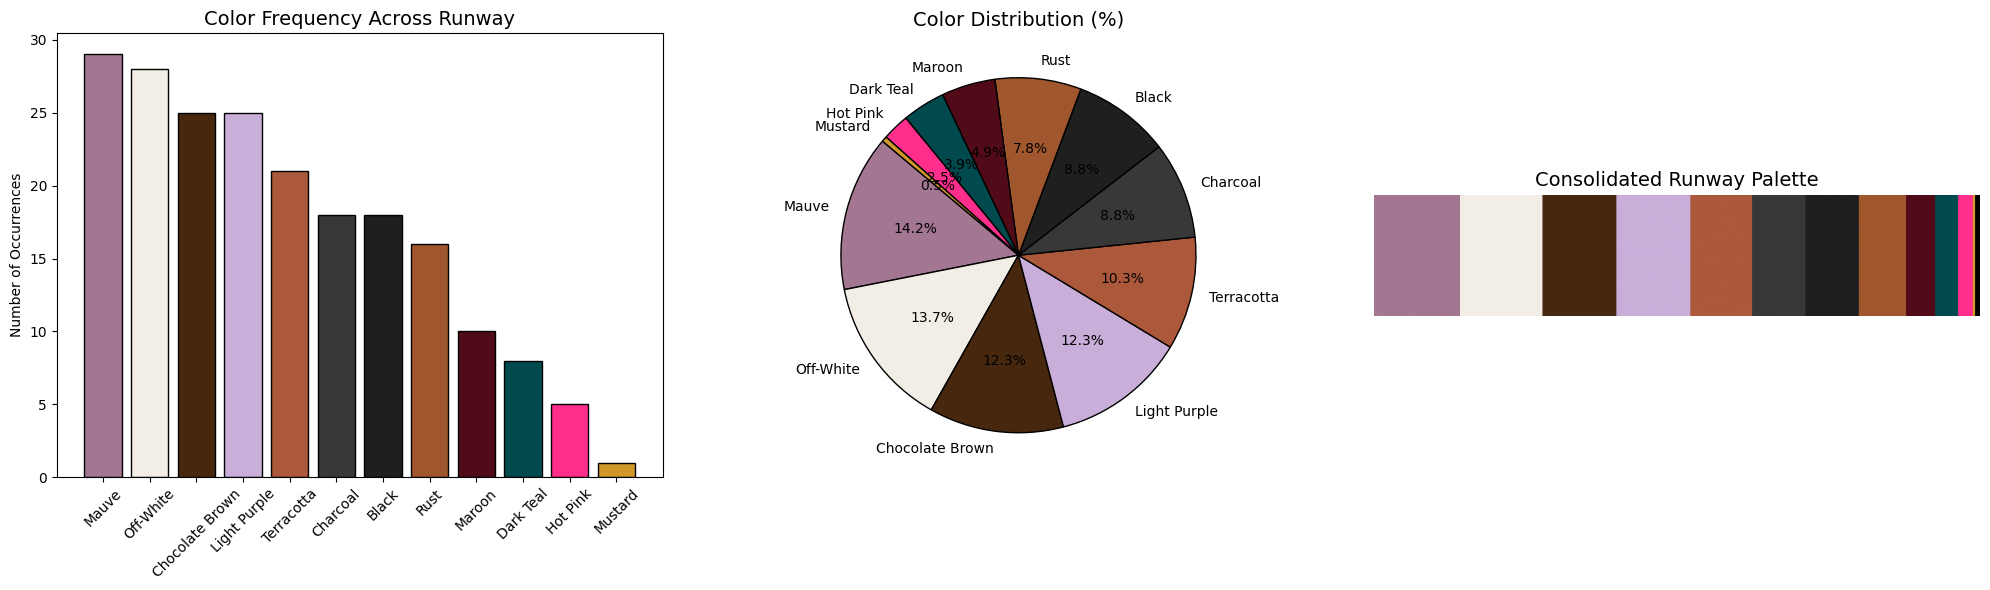

In [10]:
def name_to_lab(colour_name):
    lab_val = np.uint8([[COLOURS[colour_name]]])
    rgb_val = cv2.cvtColor(lab_val, cv2.COLOR_LAB2RGB)[0][0]
    return rgb_val / 255.0

plot_colours = [name_to_lab(colour) for colour in names]
for colour in names:
    lab = np.uint8([[COLOURS.get(colour, [0,0,0])]])
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)[0][0]/255.0
    plot_colours.append(rgb)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# A. Bar Chart: Frequency
axes[0].bar(names, counts, color=plot_colours, edgecolor='black')
axes[0].set_title('Color Frequency Across Runway', fontsize=14)
axes[0].set_ylabel('Number of Occurrences')
axes[0].tick_params(axis='x', rotation=45)

# B. Percentage Chart: Distribution
axes[1].pie(percentages, labels=names, autopct='%1.1f%%', 
            colors=plot_colours, startangle=140, wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Color Distribution (%)', fontsize=14)

# C. Color Palette: The "Runway Palette"
# We create a simple strip showing the dominant colors in order
palette_img = np.zeros((100, 500, 3))
start = 0
for i, perc in enumerate(percentages):
    end = start + int((perc / 100) * 500)
    palette_img[:, start:end] = plot_colours[i]
    start = end

axes[2].imshow(palette_img)
axes[2].axis('off')
axes[2].set_title('Consolidated Runway Palette', fontsize=14)

plt.tight_layout()
plt.show()

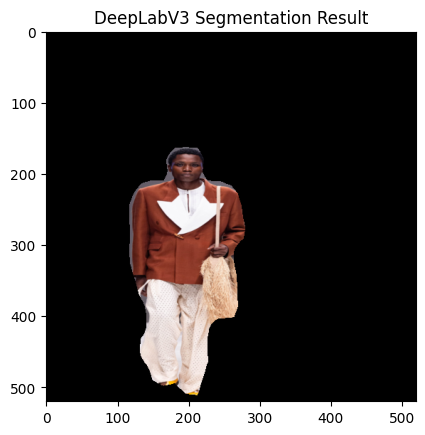

: 

In [ ]:
# Show the result of DeepLabV3 for the first image
plt.imshow(garment_img[kasbit][10])
plt.title("DeepLabV3 Segmentation Result")
plt.show()